# Loading The Data

In [310]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')

all_data = pd.concat([data, test_data])
all_data.reset_index(drop=True, inplace=True)

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Drop the redundant PassengerId (Index+1) and view data description.

In [311]:
data = data.drop(columns=['PassengerId'])

data.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Van Impe, Miss. Catharina",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


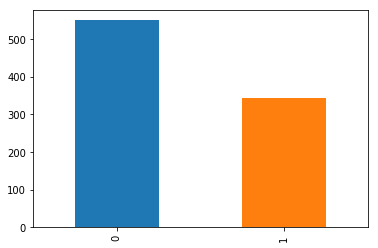

In [312]:
data.Survived.value_counts().plot(kind='bar')

## Extracting New Features

We need the title extracted from each name. Titles are suggestive of age, stratum, etc.

In [313]:
data['Title'] = data.Name.str.extract('([A-Za-z]+)\\.', expand=False)

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [314]:
titles = data.Title.unique()

print(len(titles), " Total Titles")
print(titles)

17  Total Titles
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


We can also study the last name and first name separately. 

The same family are likely to board the same boat. And names are a good supplement to the missing age data as specific names are popular in specific eras. Furthermore, they can be an indicative of race/ethnicity.

In [315]:
data['LName'] = data.Name.str.extract('([A-Za-z]+),', expand=False)

# The fate of families is likely linked, solo LNames are not important
# Some families might have been split between train and test, but one member is not predictive enough of the entire family
vc = data.LName.value_counts()
other = vc[vc < 2]
other[:] = 'Other'
data.LName = data.LName.replace(other)

# First, get the first name for married women
data['FName'] = data.Name.str.extract('\\(([A-Za-z]+)', expand=False)
# Then get the rest of the names
data.loc[data.FName.isnull(), 'FName'] = data.Name[data.FName.isnull()].str.extract('\\.\s([A-Za-z]+)', expand=False)

# We are only interested in rather popular names 
# This could help as some names are short or suggestive of a different ages etc
vc = data.FName.value_counts()
other = vc[vc < 4]
other[:] = 'Other'
data.FName = data.FName.replace(other)

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LName,FName
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,Other
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Other,Florence
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Other,Other
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Other
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,William


The Deck letter should be extracted from known cabins. The cabin itself is probably not that important, especially with so many missing values and so many cabins.

In [316]:
data.Cabin.fillna('U', inplace=True)  # U for Unknown
data['Deck'] = data.Cabin.apply(lambda x: x[0])

data['FamilySize'] = all_data.Parch + all_data.SibSp

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LName,FName,Deck,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,Braund,Other,U,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Other,Florence,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,Other,Other,U,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Other,C,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,Allen,William,U,0


In [317]:
data.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LName,FName,Deck,FamilySize
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,891,889,891,891,891,891,891.000000
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,148,3,17,134,48,9,NaN
top,NaN,NaN,"Van Impe, Miss. Catharina",male,NaN,NaN,NaN,CA. 2343,NaN,U,S,Mr,Other,Other,U,NaN
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,687,644,517,533,527,687,NaN
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,NaN,NaN,NaN,NaN,0.904602
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN,NaN,NaN,NaN,NaN,1.613459
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Drop the columns we will no longer use.

In [318]:
data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LName,FName,Deck,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,Mr,Braund,Other,U,1
1,1,1,female,38.0,1,0,71.2833,C,Mrs,Other,Florence,C,1
2,1,3,female,26.0,0,0,7.9250,S,Miss,Other,Other,U,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs,Futrelle,Other,C,1
4,0,3,male,35.0,0,0,8.0500,S,Mr,Allen,William,U,0


In [319]:
data.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LName,FName,Deck,FamilySize
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889,891,891,891,891,891.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,17,134,48,9,NaN
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Mr,Other,Other,U,NaN
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644,517,533,527,687,NaN
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN,NaN,NaN,NaN,0.904602
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN,NaN,NaN,NaN,1.613459
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN,NaN,NaN,NaN,0.000000
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN,NaN,NaN,NaN,0.000000
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN,NaN,NaN,NaN,1.000000


# Feature Exploration

We need to clean some missing values in Embarked

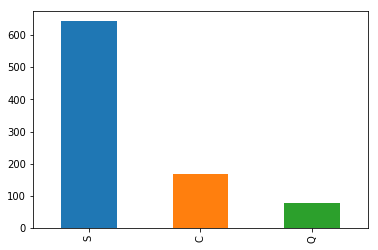

In [320]:
data.Embarked.value_counts().plot(kind='bar')

In [321]:
data.Embarked.fillna('S', inplace=True)  # A big probability for S vs other ports

Now we will do a quick analysis to compare different attributes to survivability. This can help us deal with the missing Age data and will help in model-development later.

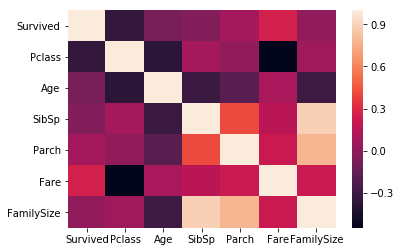

In [322]:
sns.heatmap(data.corr())

In [323]:
def breakdown_desc(attrib, eff_attrib, kind='bar', data=data):
    values = data[attrib].unique()
    count = len(values)
    cols = min(count, 5)
    rows = count // cols + 1
    fig = plt.figure(figsize=(cols*3, rows*3))
    
    i=1
    for val in np.sort(values):
        fig.add_subplot(rows, cols, i)
        plt.title(attrib + ' : ' + str(val))
        data[eff_attrib][data[attrib] == val].value_counts().sort_index().plot(kind=kind)
        i += 1
        plt.xlabel(eff_attrib)
        plt.ylabel('Count')
    plt.tight_layout()

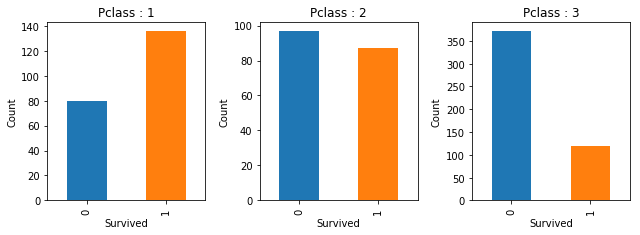

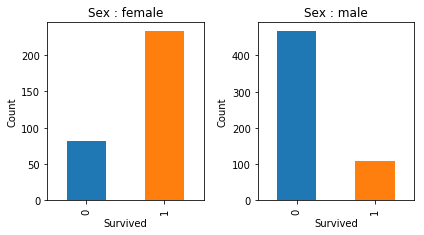

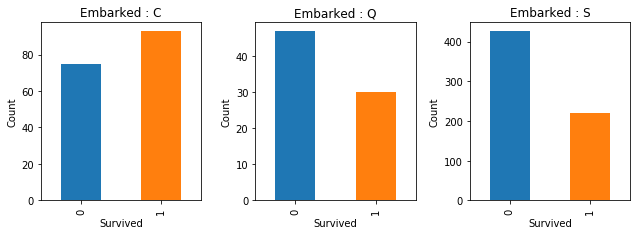

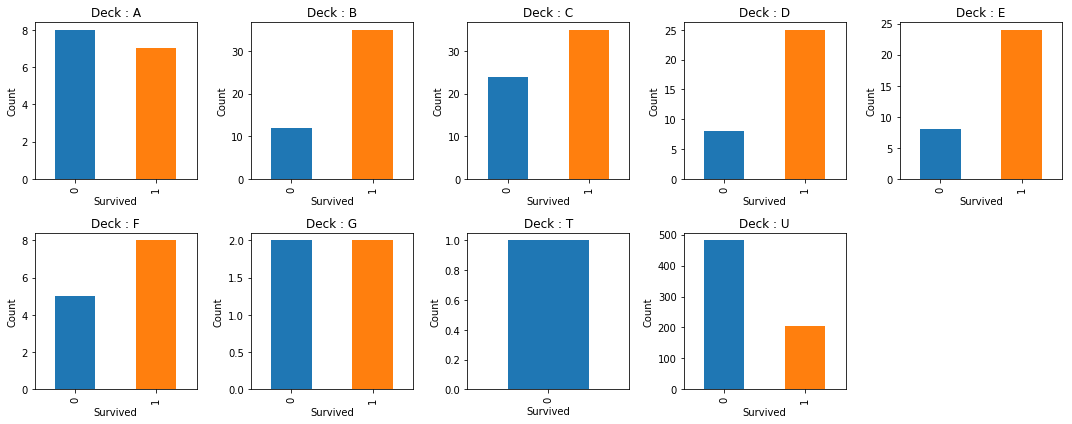

In [324]:
for attrib in ['Pclass', 'Sex', 'Embarked', 'Deck']:
    breakdown_desc(attrib, 'Survived')

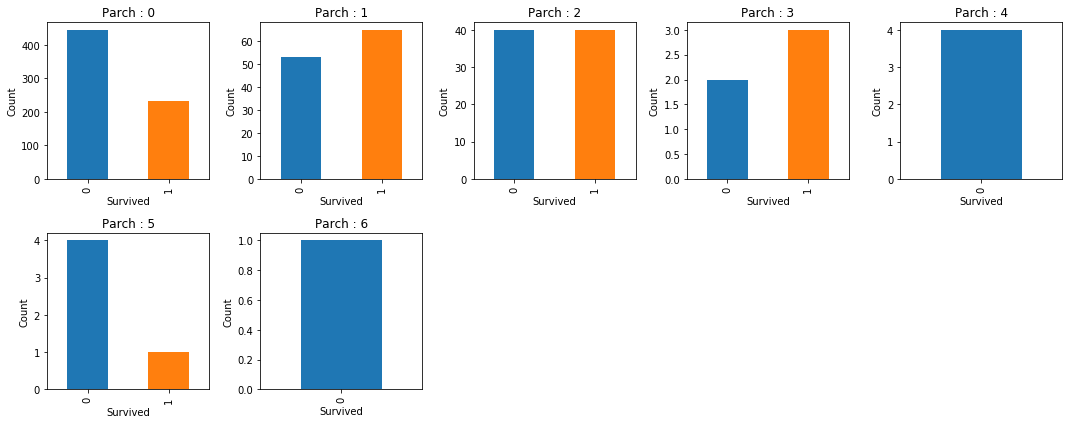

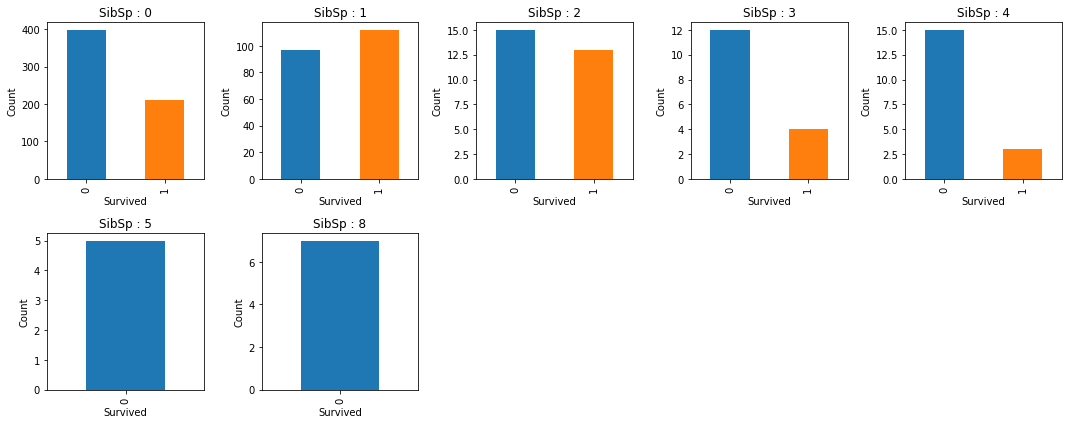

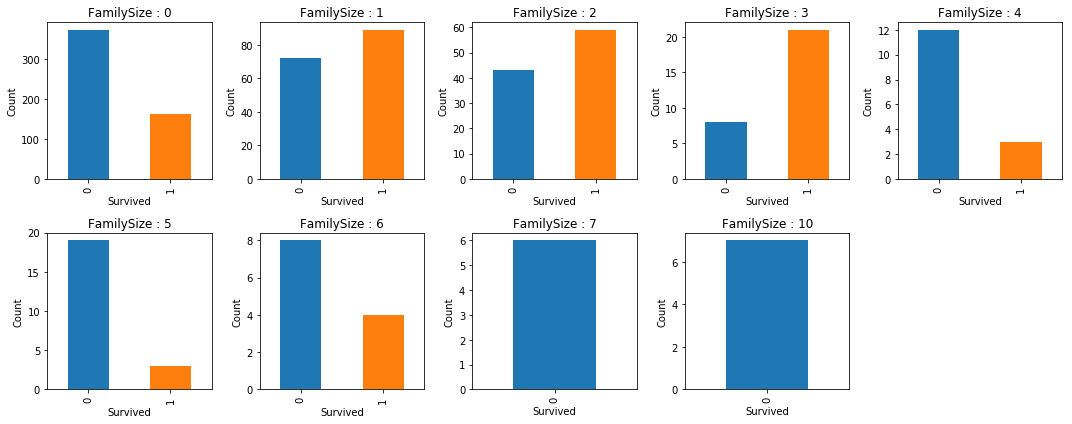

In [325]:
for attrib in ['Parch', 'SibSp', 'FamilySize']:
    breakdown_desc(attrib, 'Survived')

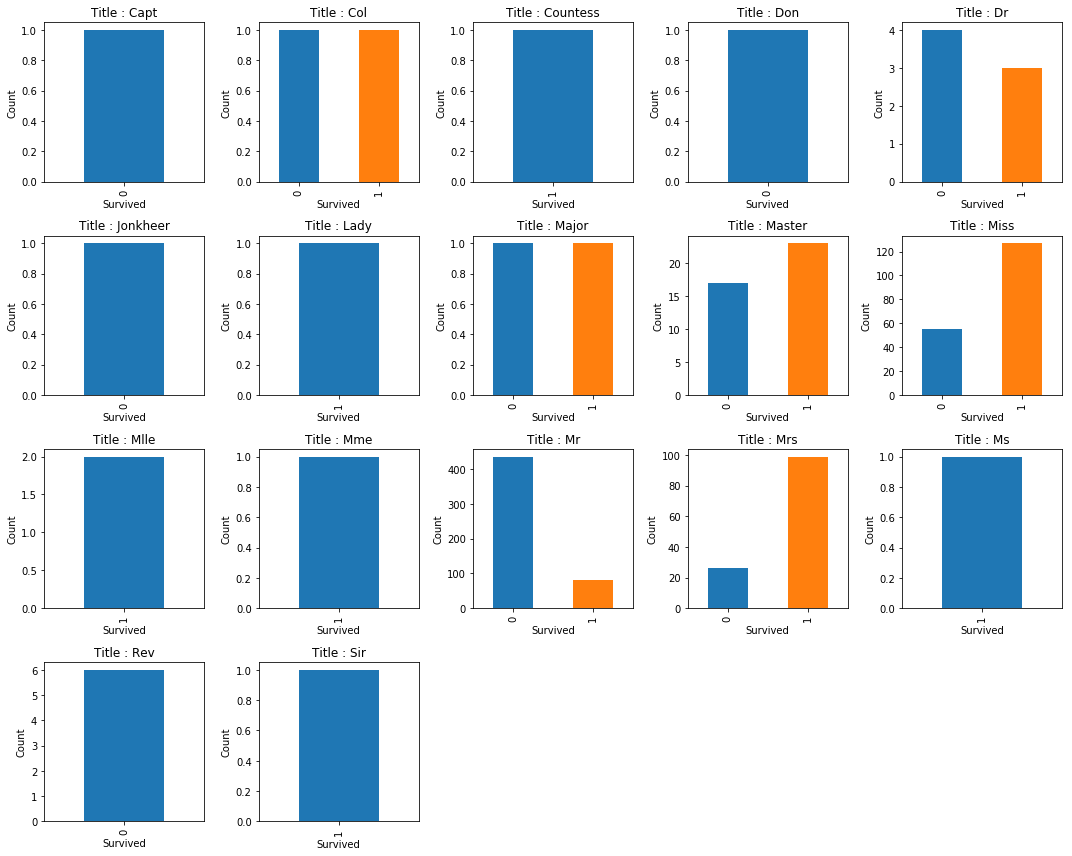

In [326]:
breakdown_desc('Title', 'Survived')

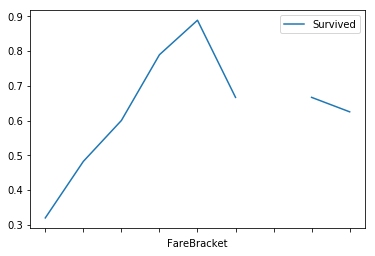

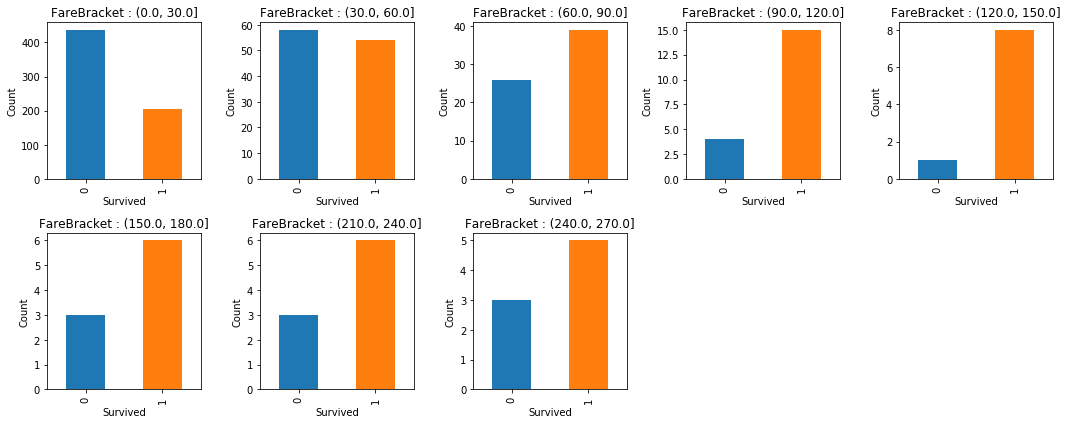

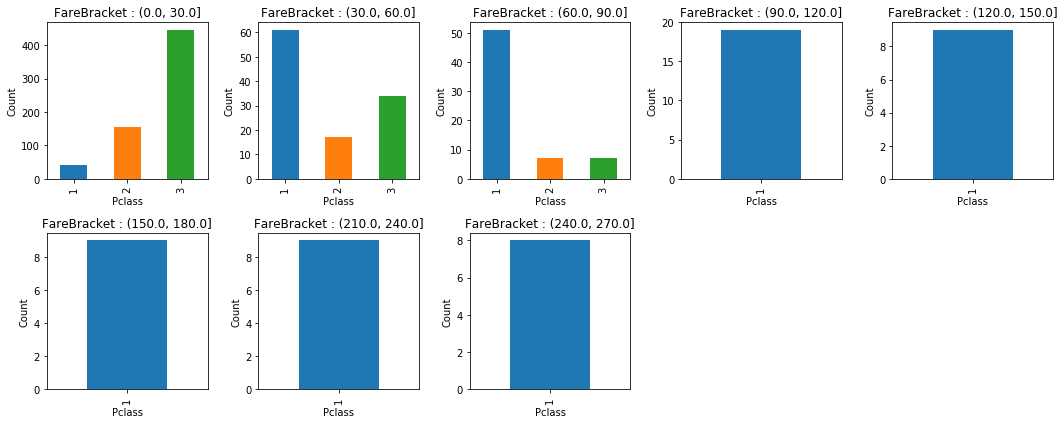

In [327]:
f_bins = np.arange(data.Fare.min(), data.Fare.max(), 30)

data['FareBracket'] = pd.cut(data.Fare, f_bins)


p_surv = data.loc[~data.Fare.isnull(), ['FareBracket', 'Survived']].groupby(by='FareBracket').mean()
p_surv.plot(kind='line')

breakdown_desc('FareBracket', 'Survived', data=data[~data.FareBracket.isnull()])

breakdown_desc('FareBracket', 'Pclass', data=data[~data.FareBracket.isnull()])

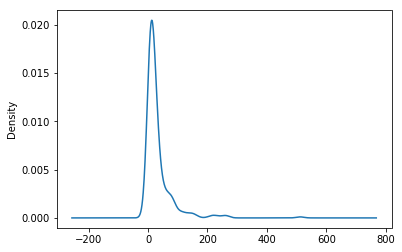

In [328]:
data.Fare.plot(kind='density')

An average fare seems to have the highest survival probability. This is probably due the Age factor.

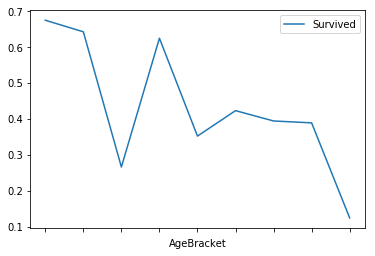

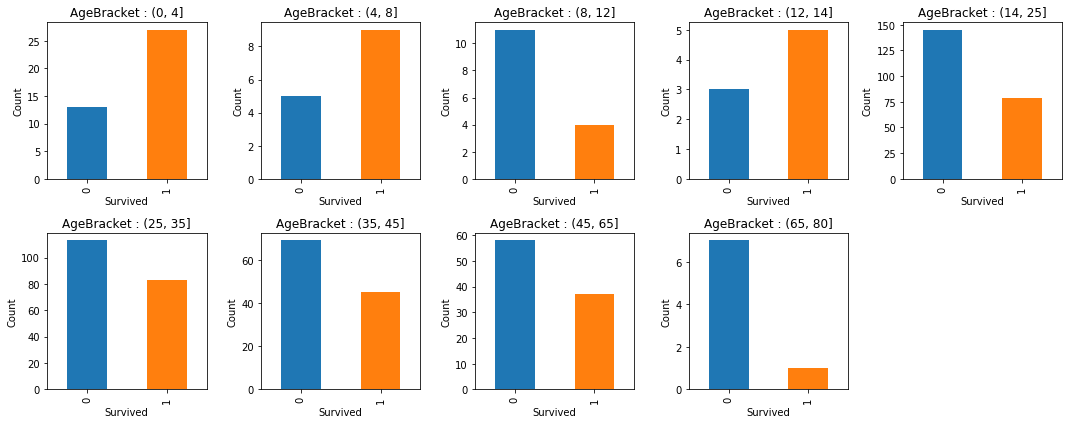

In [329]:
bins = [0, 4, 8, 12, 14, 25, 35, 45, 65, 80]
data['AgeBracket'] = pd.cut(data.Age, bins)


p_surv = data.loc[~data.Age.isnull(), ['AgeBracket', 'Survived']].groupby(by='AgeBracket').mean()
p_surv.plot(kind='line')

breakdown_desc('AgeBracket', 'Survived', data=data[~data.AgeBracket.isnull()])

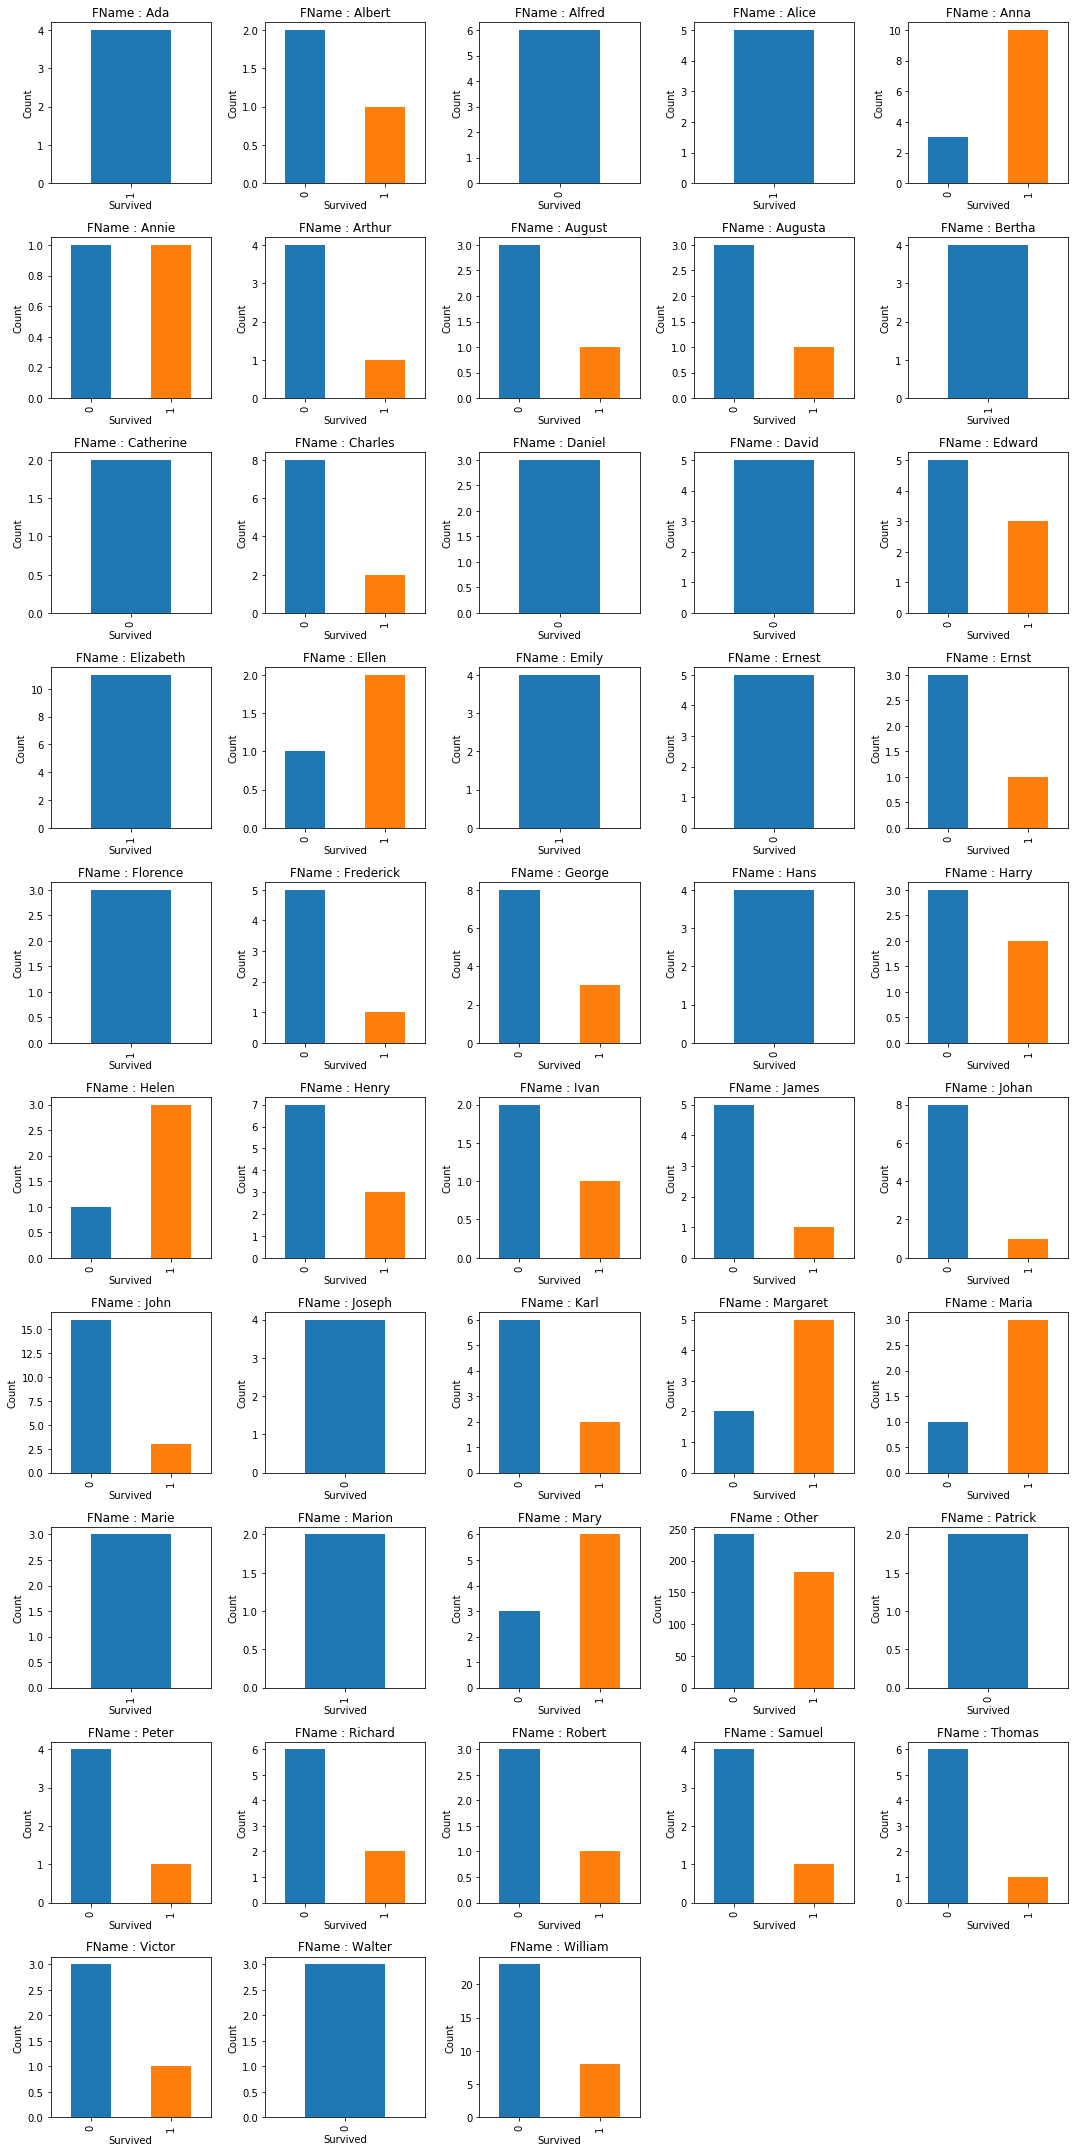

In [330]:
breakdown_desc('FName', 'Survived', data=data[~data.AgeBracket.isnull()])

We need to analyze how Age is related to other attributes.

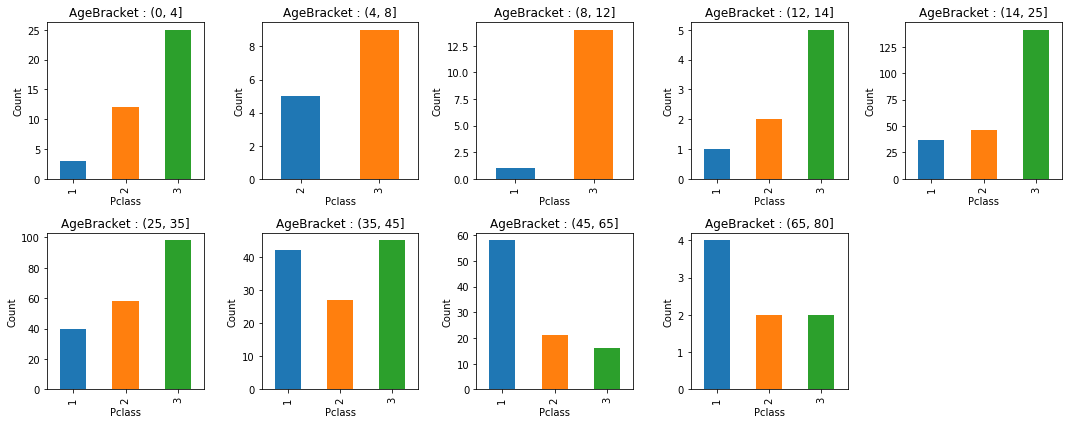

In [331]:
breakdown_desc('AgeBracket', 'Pclass', data=data[~data.AgeBracket.isnull()])

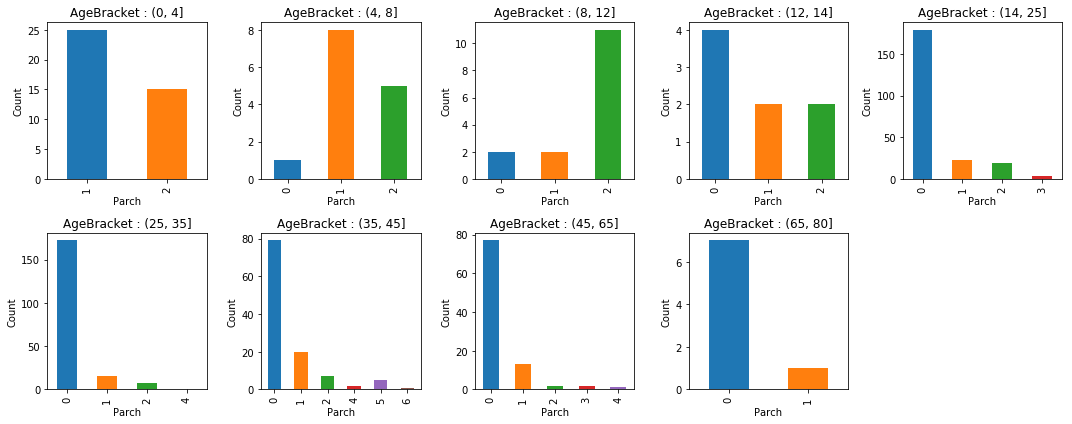

In [332]:
breakdown_desc('AgeBracket', 'Parch', data=data[~data.AgeBracket.isnull()])

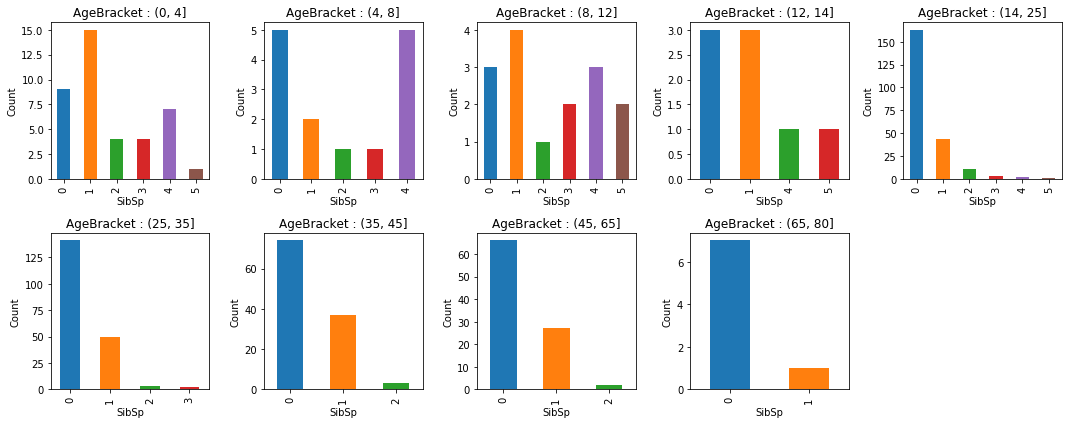

In [333]:
breakdown_desc('AgeBracket', 'SibSp', data=data[~data.AgeBracket.isnull()])

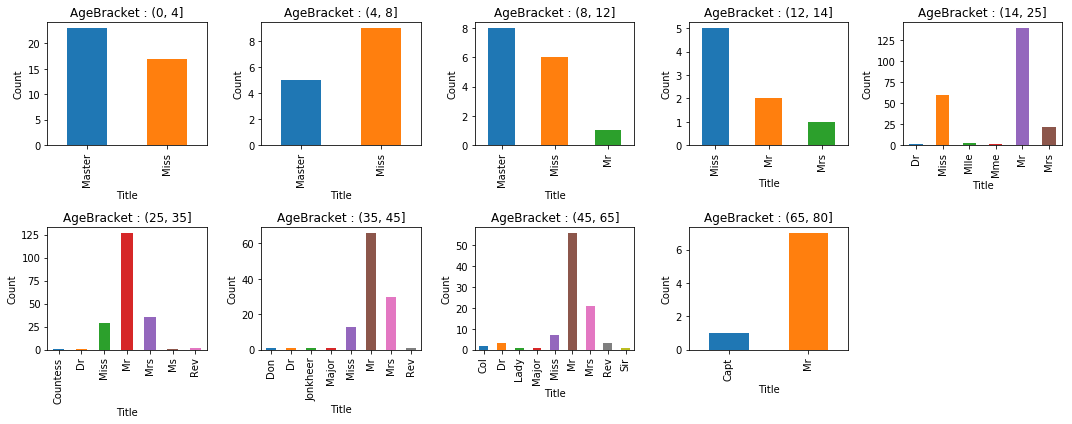

In [334]:
breakdown_desc('AgeBracket', 'Title', data=data[~data.AgeBracket.isnull()])

There are obvious trends in Pclass, Title, Parch, SibSp that would suggest we can make use of them to predict the age bracket. However, the title seems to be the most suggestive feature to age.

A quick analysis of how predictable the AgeBracket is.

In [335]:
all_data['Title'] = all_data.Name.str.extract('([A-Za-z]+)\\.', expand=False)
all_data['AgeBracket'] = pd.cut(all_data.Age, bins)

data_with_age = all_data[~all_data.AgeBracket.isnull()][['Pclass', 'Title', 'Parch', 'SibSp', 'AgeBracket']].copy()
ab_enc = LabelEncoder()
data_with_age.AgeBracket = ab_enc.fit_transform(data_with_age.AgeBracket)

data_with_age = pd.get_dummies(data_with_age, columns=['Pclass', 'Title'])

X = data_with_age.drop(columns=['AgeBracket'])
y = data_with_age.AgeBracket.iloc[:]

age_clf = RandomForestClassifier()

age_clf.fit(X, y)

pred = age_clf.predict(X)

acc = accuracy_score(y, pred)

print("Exact Bracket Accuracy %2.2f%%"%(acc*100))

err = np.abs(y-pred)
err = err[err > 0]  # Only the wrong assumptions

print("Total Brackets:", len(bins)-1)
print("Avg. Bracket Error: %2.2f"%np.mean(err))
print("Max. Bracket Error: %2.2f"%np.max(err))
print("Std. Bracket Error: %2.2f"%np.std(err))

Exact Bracket Accuracy 50.48%
Total Brackets: 9
Avg. Bracket Error: 1.53
Max. Bracket Error: 4.00
Std. Bracket Error: 0.76


# Data Processing

Now we need to use what we learned to process a learning-ready dataset. We need to process all the data to ensure consistency between values in the train and test sets.

In [336]:
all_data.describe(include='all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,AgeBracket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309,1309,1046
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929,18,9
top,NaN,C23 C25 C27,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA. 2343,Mr,"(14, 25]"
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11,757,336
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN,NaN,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN,NaN,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN,NaN,NaN


The Deck, Title features seem useful so we need to calculate the Deck feature for all data now.

In [337]:
all_data.Cabin.fillna('U', inplace=True)  # U for Unknown
all_data['Deck'] = all_data.Cabin.apply(lambda x: x[0])

We need to map the Sex attribute and drop columns we will not use.

In [338]:
all_data.Sex = all_data.Sex.map({'male':1, 'female':0})

all_data.drop(columns=['Age', 'Cabin', 'Name', 'Ticket'], inplace=True)

In [339]:
all_data.Embarked.fillna('S', inplace=True)
all_data.Embarked = LabelEncoder().fit_transform(all_data.Embarked)

In [340]:
all_data.Deck = LabelEncoder().fit_transform(all_data.Deck)

In [341]:
fare_avg = data.loc[~data.Fare.isnull(), ['Fare', 'Pclass']].groupby(by='Pclass').mean()

for idx in all_data.index[all_data.Fare.isnull()]:
    row = all_data.loc[idx]
    value = fare_avg.loc[row['Pclass']]['Fare']
    all_data.loc[idx, 'Fare'] = value
    
all_data['FareBracket'] = pd.cut(all_data.Fare, f_bins)

all_data.drop(columns=['Fare'], inplace=True)

In [342]:
all_data.describe(include='all')

,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,AgeBracket,Deck,FareBracket
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000,1309,1046,1309.000000,1288
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,9,NaN,8
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mr,"(14, 25]",NaN,"(0.0, 30.0]"
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,757,336,NaN,949
mean,1.493506,0.385027,655.000000,2.294882,0.644003,0.498854,0.383838,NaN,NaN,6.729565,NaN
std,0.814244,0.865560,378.020061,0.837836,0.478997,1.041658,0.486592,NaN,NaN,2.454520,NaN
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN
25%,1.000000,0.000000,328.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN,8.000000,NaN
50%,2.000000,0.000000,655.000000,3.000000,1.000000,0.000000,0.000000,NaN,NaN,8.000000,NaN
75%,2.000000,0.000000,982.000000,3.000000,1.000000,1.000000,1.000000,NaN,NaN,8.000000,NaN


In [343]:
all_data.head()

,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,AgeBracket,Deck,FareBracket
0,2,0,1,3,1,1,0.0,Mr,"(14, 25]",8,"(0.0, 30.0]"
1,0,0,2,1,0,1,1.0,Mrs,"(35, 45]",2,"(60.0, 90.0]"
2,2,0,3,3,0,0,1.0,Miss,"(25, 35]",8,"(0.0, 30.0]"
3,2,0,4,1,0,1,1.0,Mrs,"(25, 35]",2,"(30.0, 60.0]"
4,2,0,5,3,1,0,0.0,Mr,"(25, 35]",8,"(0.0, 30.0]"


In [344]:
all_data_proc = pd.get_dummies(all_data, columns=['Pclass', 'Title', 'Deck', 'FareBracket'])

data_train_proc = all_data_proc[~all_data.Survived.isnull()]
data_test_proc = all_data_proc[all_data.Survived.isnull()].drop(columns=['Survived'])

In [345]:
data_train_proc.head()

,Embarked,Parch,PassengerId,Sex,SibSp,Survived,AgeBracket,Pclass_1,Pclass_2,Pclass_3,...,"FareBracket_(210.0, 240.0]","FareBracket_(240.0, 270.0]","FareBracket_(270.0, 300.0]","FareBracket_(300.0, 330.0]","FareBracket_(330.0, 360.0]","FareBracket_(360.0, 390.0]","FareBracket_(390.0, 420.0]","FareBracket_(420.0, 450.0]","FareBracket_(450.0, 480.0]","FareBracket_(480.0, 510.0]"
0,2,0,1,1,1,0.0,"(14, 25]",0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,1,1.0,"(35, 45]",1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,3,0,0,1.0,"(25, 35]",0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2,0,4,0,1,1.0,"(25, 35]",1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,5,1,0,0.0,"(25, 35]",0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Test Model

In [346]:
no_age_tr = data_train_proc.AgeBracket.isnull()
no_age_ts = data_test_proc.AgeBracket.isnull()

X = data_train_proc.drop(columns=['Survived', 'PassengerId'])
y = data_train_proc.Survived

X_train, X_test, y_train, y_test = train_test_split(X[no_age_tr].drop(columns=['AgeBracket']), y[no_age_tr],
                                                    test_size=0.2)

clf = RandomForestClassifier()
# clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

print(accuracy_score(y_test, clf.predict(X_test)))

pred_noage = clf.predict(data_test_proc.drop(columns=['PassengerId'])[no_age_ts].drop(columns=['AgeBracket']))



0.8888888888888888


In [347]:
has_age_tr = ~data_train_proc.AgeBracket.isnull()
has_age_ts = ~data_test_proc.AgeBracket.isnull()

X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X[has_age_tr], columns=['AgeBracket']),
                                                    y[has_age_tr], test_size=0.2)

# clf = RandomForestClassifier()
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

print(accuracy_score(y_test, clf.predict(X_test)))

pred_hasage = clf.predict(pd.get_dummies(data_test_proc, columns=['AgeBracket'])
                          .drop(columns=['PassengerId'])[has_age_ts])

0.7762237762237763


In [348]:
df = pd.DataFrame(columns=['PassengerId', 'Survived'])
df['PassengerId'] = data_test_proc.PassengerId
df.loc[no_age_ts, 'Survived'] =  pd.to_numeric(pred_noage, downcast='integer')
df.loc[has_age_ts, 'Survived'] =  pd.to_numeric(pred_hasage, downcast='integer')

df.to_csv('output.csv', index=False)

df.Survived.value_counts()

0    263
1    155
Name: Survived, dtype: int64